# BigGAN Exploration

## Copyright notice

This version (c) 2019 Fabian Offert, [MIT License](LICENSE). 

## Architecture

While we are using a massively refined version of a GAN called BigGAN (original paper here: https://arxiv.org/abs/1809.11096), the basic architecture is the same:

![](img/gan.jpg)

## Imports

We use Tensorflow here simply because the BigGAN model is implemented in Tensorflow. We also use imageio to make animated GIFs, everything else should already be installed in your environment from previous notebooks. Please use the installation commands in the comments to install the missing packges.

In [1]:
import tensorflow as tf # pip install tensorflow
import tensorflow_hub as hub # pip install tensorflow-hub
import imageio # conda install imageio

import numpy as np
from scipy.stats import truncnorm
from io import BytesIO
import PIL.Image
import IPython.display
import os

print(tf.__version__)

1.12.0


## Load and analyze model

Tensorflow allows us to operate on models in the cloud. Here, we are using the 256x256 version of BigGAN. Replace `256`with `512` below for higher resolution output at the price of longer compute time, or use `128` for the opposite.

In [2]:
module_path = 'https://tfhub.dev/deepmind/biggan-256/2'
tf.reset_default_graph()
module = hub.Module(module_path)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/deepmind/biggan-256/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/deepmind/biggan-256/2'.


In [3]:
# Get a list of all the inputs of the model
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}

# Define graph entry and exit points
output = module(inputs)
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

# Print dimensions of latent space: note that the latent space has two multi-dimensional parts in BigGAN, 
# one for the actual latent space vector and one for the ImageNet class
DIM_Z = input_z.shape.as_list()[1]
DIM_Y = input_y.shape.as_list()[1]
print(DIM_Z, DIM_Y)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
140 1000


## Helper Functions

In [20]:
def deprocess(img):
    img = np.concatenate(img, axis=0) # "Squeeze"
    img = np.clip(((img + 1) / 2.0) * 255, 0, 255)
    img = PIL.Image.fromarray(img.astype(np.uint8))  
    return img

def show_img_PIL(img, fmt='jpeg'):
    f = BytesIO()
    img.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def truncated_z_sample(truncation=1.0):
    Z_MIN = -2
    Z_MAX = 2
    values = truncnorm.rvs(Z_MIN, Z_MAX, size=(1,DIM_Z), random_state=None)
    return truncation * values

def makegif(folder):
    images = []
    files = []
    for file in os.listdir(folder):
        files.append(folder + '/' + file)
    files = sorted(files)
    print(files)
    for file in files:
        images.append(imageio.imread(file))
    imageio.mimsave('movie.gif', images)

In [ ]:
FOLDER = 'images'

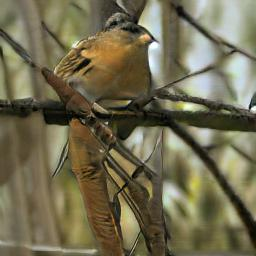

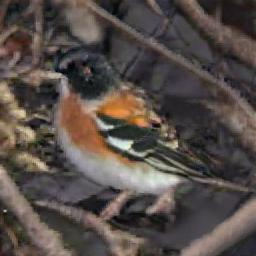

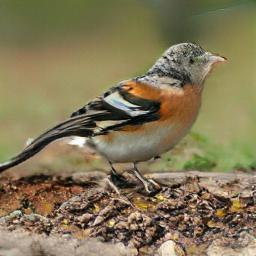

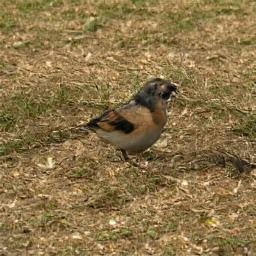

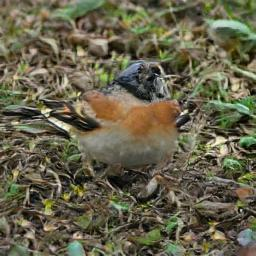

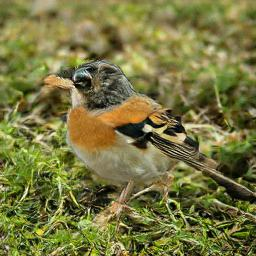

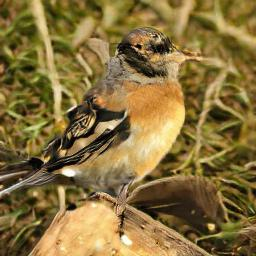

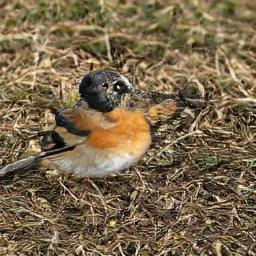

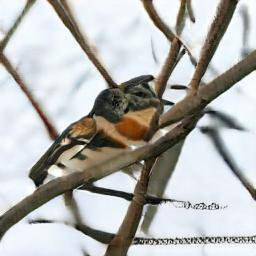

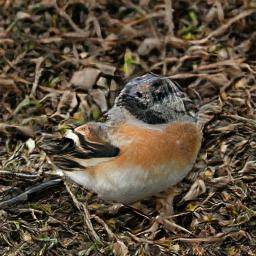

In [6]:
if not os.path.exists(FOLDER): os.makedirs(FOLDER)

initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

for i in range(10):

    z = truncated_z_sample() # Get z sample
    # y = np.random.rand(1,DIM_Y) # Set all classes to value between 0 and 1
    # y /= y.sum() # Scale vector so it adds up to 1
    y = np.zeros((1, DIM_Y)) # Set all classes to 0
    y[0,10] = 1 # Set one class to 1

    feed_dict = {input_z: z, input_y: y, input_trunc: 1.0}
    img = sess.run(output, feed_dict=feed_dict)
    img = deprocess(img)
    show_img_PIL(img)
    img.save(f'{FOLDER}/{i:03d}.jpg')
    
makegif(FOLDER)